<a href="https://colab.research.google.com/github/xili5979/CS61-1/blob/main/eye_damage_transferlearning_test_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eye Damage Detection Model Test

## Enabling and testing the TPU

In [8]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## GPU

In [9]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [10]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct  5 05:45:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |    345MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## import

In [11]:
import re
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
from tqdm import tqdm

## Set configurations and read metadata

In [12]:
#unzip file
!unzip "/content/drive/MyDrive/5703File/DataSet/ODIR-5K.zip" -d "/content"
!unzip "/content/drive/MyDrive/5703File/DataSet/cataract.zip" -d "/content"
!unrar x -r "/content/drive/MyDrive/DDR_dataset/*.rar" "/content"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/ODIR-5K/Training Images/1327_right.jpg  
  inflating: /content/ODIR-5K/Training Images/2917_left.jpg  
  inflating: /content/ODIR-5K/Training Images/2587_left.jpg  
  inflating: /content/ODIR-5K/Training Images/834_left.jpg  
  inflating: /content/ODIR-5K/Training Images/2112_right.jpg  
  inflating: /content/ODIR-5K/Training Images/2916_left.jpg  
  inflating: /content/ODIR-5K/Training Images/2438_right.jpg  
  inflating: /content/ODIR-5K/Training Images/2586_left.jpg  
  inflating: /content/ODIR-5K/Training Images/835_left.jpg  
  inflating: /content/ODIR-5K/Training Images/90_right.jpg  
  inflating: /content/ODIR-5K/Training Images/59_right.jpg  
  inflating: /content/ODIR-5K/Training Images/2923_right.jpg  
  inflating: /content/ODIR-5K/Training Images/2149_left.jpg  
  inflating: /content/ODIR-5K/Training Images/4240_left.jpg  
  inflating: /content/ODIR-5K/Training Images/3381_left.jpg  
  inflating: /content/ODIR-5K/Training Imag

In [13]:
# !unzip "/content/drive/MyDrive/5703File/DataSet/DDR_dataset/DDR-dataset.zip.001.zip" -d "/content"

In [14]:
# cataract dataset
IMG_ROOT = '/content/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal', 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma', 
           IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
OCU_IMG_ROOT = '/content/ODIR-5K/Training Images/'
ocu_df = pd.read_csv('/content/ODIR-5K/full_df.csv')

In [15]:
# restore the data


### use PyDrive

In [16]:
SEED = 42
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

## Process Cataract dataset

In [17]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'disease'],
                  index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3
        
# only sample normal and cataract and other disease      
cat_df = cat_df.query('0 <= disease < 2 or disease == 3')
# cat_df = cat_df.query('disease == 3')
cat_df

# can 

,paths,disease
0,/content/dataset/2_cataract/cataract_027.png,1
1,/content/dataset/2_cataract/cataract_053.png,1
2,/content/dataset/2_cataract/cataract_023.png,1
3,/content/dataset/2_cataract/cataract_030.png,1
4,/content/dataset/2_cataract/cataract_098.png,1
...,...,...
596,/content/dataset/1_normal/NL_245.png,0
597,/content/dataset/1_normal/NL_084.png,0
598,/content/dataset/1_normal/NL_058.png,0
599,/content/dataset/1_normal/NL_183.png,0


In [18]:
print('Number of normal(0) and cataract(1) and other_disease(3) images')
print(cat_df['disease'].value_counts())

Number of normal(0) and cataract(1) and other_disease(3) images
0    300
3    100
1    100
Name: disease, dtype: int64


## Process Ocular Disease Dataset

In [19]:
ocu_df.head()
# I only need filename and lables
# N-normal-0, C-cataract-1, A-AMD-4, D,G,H,M,O-Others-3

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [20]:
ocu_df.shape

(6392, 19)

In [21]:
new_ocu_df = ocu_df.loc[:,['filename','labels']]
new_ocu_df.columns = ['paths','disease']

In [22]:
new_ocu_df

,paths,disease
0,0_right.jpg,['N']
1,1_right.jpg,['N']
2,2_right.jpg,['D']
3,4_right.jpg,['D']
4,5_right.jpg,['D']
...,...,...
6387,4686_left.jpg,['D']
6388,4688_left.jpg,['D']
6389,4689_left.jpg,['D']
6390,4690_left.jpg,['D']


In [23]:
def change_label(text):
    if 'N' in text:
        return 0
    if 'C' in text:
        return 1
    if 'A' in text:
        return 2
    if 'D' in text:
        return 7
    if 'G' in text:
        return 7
    if 'H' in text:
        return 7
    if 'M' in text:
        return 7
    if 'O' in text:
        return 7

def add_filepath(text):
    str = OCU_IMG_ROOT + text
    return str
new_ocu_df['paths'] = new_ocu_df['paths'].apply(lambda x : add_filepath(x))
new_ocu_df['disease'] = new_ocu_df['disease'].apply(lambda x : change_label(x))
new_ocu_df['disease'] = new_ocu_df['disease'].astype(int)

In [24]:
new_ocu_df

,paths,disease
0,/content/ODIR-5K/Training Images/0_right.jpg,0
1,/content/ODIR-5K/Training Images/1_right.jpg,0
2,/content/ODIR-5K/Training Images/2_right.jpg,7
3,/content/ODIR-5K/Training Images/4_right.jpg,7
4,/content/ODIR-5K/Training Images/5_right.jpg,7
...,...,...
6387,/content/ODIR-5K/Training Images/4686_left.jpg,7
6388,/content/ODIR-5K/Training Images/4688_left.jpg,7
6389,/content/ODIR-5K/Training Images/4689_left.jpg,7
6390,/content/ODIR-5K/Training Images/4690_left.jpg,7


In [25]:
print('Number of normal(0) and cataract(1) and A(2) and G(4) images')
print(new_ocu_df['disease'].value_counts())

Number of normal(0) and cataract(1) and A(2) and G(4) images
7    2960
0    2873
1     293
2     266
Name: disease, dtype: int64


down sample


In [26]:
def downsample(df):
    df = pd.concat([
        df.query('disease==1'),
        df.query('disease==2'),
        # df.query('disease==4'),
        df.query('disease==0').sample(300,random_state=SEED)
        # df.query('disease==3').sample(300,random_state=SEED)
    ])
    return df

new_ocu_df = downsample(new_ocu_df)

print('Number of normal(0) and cataract(1) and other_disease(3) and AMD(4) and G(5) images')
print(new_ocu_df['disease'].value_counts())

Number of normal(0) and cataract(1) and other_disease(3) and AMD(4) and G(5) images
0    300
1    293
2    266
Name: disease, dtype: int64


## Create datasets

In [27]:
df = pd.concat([cat_df, new_ocu_df], ignore_index=True)
# df = cat_df
df
print(df['disease'].value_counts())

0    600
1    393
2    266
3    100
Name: disease, dtype: int64


In [28]:
#for transfer learning test
df1, df2 = train_test_split(df, 
                        test_size=0.5, 
                        random_state=SEED, 
                        stratify=df['disease'])
print(df1['disease'].value_counts())
print(df2['disease'].value_counts())

0    300
1    196
2    133
3     50
Name: disease, dtype: int64
0    300
1    197
2    133
3     50
Name: disease, dtype: int64


In [29]:
df

,paths,disease
0,/content/dataset/2_cataract/cataract_027.png,1
1,/content/dataset/2_cataract/cataract_053.png,1
2,/content/dataset/2_cataract/cataract_023.png,1
3,/content/dataset/2_cataract/cataract_030.png,1
4,/content/dataset/2_cataract/cataract_098.png,1
...,...,...
1354,/content/ODIR-5K/Training Images/3030_left.jpg,0
1355,/content/ODIR-5K/Training Images/3169_right.jpg,0
1356,/content/ODIR-5K/Training Images/125_right.jpg,0
1357,/content/ODIR-5K/Training Images/2487_left.jpg,0


In [30]:
train_df_1, test_df_1 = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['disease'])

train_df_1, val_df_1 = train_test_split(train_df_1,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df_1['disease'])

In [31]:
#for transfer learning first half data
train_df_1_tran, test_df_1_tran = train_test_split(df1, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df1['disease'])

train_df_1_tran, val_df_1_tran = train_test_split(train_df_1_tran,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df_1_tran['disease'])

In [32]:
#for transfer learning second half data
train_df_2_tran, test_df_2_tran = train_test_split(df2, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df2['disease'])

train_df_2_tran, val_df_2_tran = train_test_split(train_df_2_tran,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df_2_tran['disease'])

In [33]:
print(val_df_2_tran.value_counts())

paths                                             disease
/content/dataset/3_retina_disease/Retina_096.png  3          1
/content/ODIR-5K/Training Images/2179_right.jpg   1          1
/content/ODIR-5K/Training Images/2181_left.jpg    1          1
/content/ODIR-5K/Training Images/2198_left.jpg    1          1
/content/ODIR-5K/Training Images/2200_left.jpg    1          1
                                                            ..
/content/dataset/1_normal/NL_040.png              0          1
/content/dataset/1_normal/NL_054.png              0          1
/content/dataset/1_normal/NL_061.png              0          1
/content/dataset/1_normal/NL_071.png              0          1
/content/ODIR-5K/Training Images/102_left.jpg     2          1
Length: 82, dtype: int64


In [34]:
test_df_1

,paths,disease
704,/content/ODIR-5K/Training Images/2125_left.jpg,1
691,/content/ODIR-5K/Training Images/2108_left.jpg,1
391,/content/dataset/1_normal/NL_066.png,0
150,/content/dataset/3_retina_disease/Retina_048.png,3
521,/content/ODIR-5K/Training Images/1454_right.jpg,1
...,...,...
136,/content/dataset/3_retina_disease/Retina_038.png,3
1218,/content/ODIR-5K/Training Images/3171_left.jpg,0
1057,/content/ODIR-5K/Training Images/2053_left.jpg,2
473,/content/dataset/1_normal/NL_137.png,0


## image size

In [35]:
# #1 size
# IMG_HEIGHT = 192
# IMG_WIDTH = 256
# #2 size
# IMG_HEIGHT = 288
# IMG_WIDTH = 384
# 3 size
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [36]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # change the img to square
        height = img.shape[0]
        width = img.shape[1]
        img = img[0:height,int((width-height)/2):int((width-(width-height)/2))]
        #
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['disease'])
    return imgs, df

#whole datasets
train_imgs, train_df = create_datasets(train_df_1, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df_1, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df_1, IMG_WIDTH, IMG_HEIGHT)

#first datasets
train_imgs_1_tran, train_df_1_tran = create_datasets(train_df_1_tran, IMG_WIDTH, IMG_HEIGHT)
val_imgs_1_tran, val_df_1_tran = create_datasets(val_df_1_tran, IMG_WIDTH, IMG_HEIGHT)
test_imgs_1_tran, test_df_1_tran = create_datasets(test_df_1_tran, IMG_WIDTH, IMG_HEIGHT)
#second datasets
train_imgs_2_tran, train_df_2_tran = create_datasets(train_df_2_tran, IMG_WIDTH, IMG_HEIGHT)
val_imgs_2_tran, val_df_2_tran = create_datasets(val_df_2_tran, IMG_WIDTH, IMG_HEIGHT)
test_imgs_2_tran, test_df_2_tran = create_datasets(test_df_2_tran, IMG_WIDTH, IMG_HEIGHT)


100%|██████████| 136/136 [00:07<00:00, 17.49it/s]


In [37]:
train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

train_imgs_1_tran = train_imgs_1_tran / 255.0
val_imgs_1_tran = val_imgs_1_tran / 255.0
test_imgs_1_tran = test_imgs_1_tran / 255.0

train_imgs_2_tran = train_imgs_2_tran / 255.0
val_imgs_2_tran = val_imgs_2_tran / 255.0
test_imgs_2_tran = test_imgs_2_tran / 255.0

## Epochs and batch size

In [38]:
EPOCHS = 100
BATCH_SIZE = 32

## Build the model (Xception)

In [39]:
# Xception = tf.keras.applications.Xception(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], weights='imagenet', include_top=False)
# Xception.summary()

In [40]:
def create_model():
  pretrained_model = tf.keras.applications.Xception(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], weights='imagenet', include_top=False)
  pretrained_model.trainable = True
#   pretrained_model.trainable = False
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model_Xception = create_model()
model_Xception.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [41]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
14/14 [==============================] - 29s 556ms/step - loss: 0.9138 - accuracy: 0.6421 - val_loss: 2.5599 - val_accuracy: 0.5732
Epoch 2/100
14/14 [==============================] - 7s 462ms/step - loss: 0.6347 - accuracy: 0.7397 - val_loss: 4.6716 - val_accuracy: 0.5244
Epoch 3/100
14/14 [==============================] - 7s 457ms/step - loss: 0.4840 - accuracy: 0.8134 - val_loss: 2.1167 - val_accuracy: 0.6951
Epoch 4/100
14/14 [==============================] - 7s 476ms/step - loss: 0.3616 - accuracy: 0.8547 - val_loss: 2.0349 - val_accuracy: 0.6829
Epoch 5/100
14/14 [==============================] - 7s 458ms/step - loss: 0.3274 - accuracy: 0.8633 - val_loss: 1.4483 - val_accuracy: 0.6951
Epoch 6/100
14/14 [==============================] - 7s 460ms/step - loss: 0.3567 - accuracy: 0.8698 - val_loss: 1.4520 - val_accuracy: 0.7683
Epoch 7/100
14/14 [==============================] - 7s 460ms/step - loss: 0.2211 - accuracy: 0.9154 - val_loss: 1.7812 - val_accuracy: 0.780

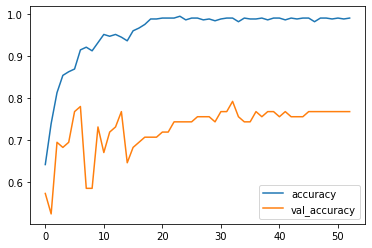

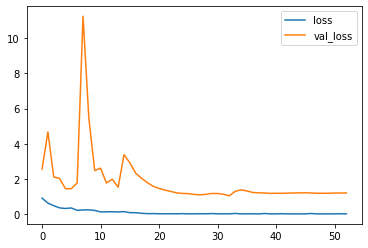

In [42]:
history = model_Xception.fit(generator.flow(train_imgs_1_tran, 
                                   train_df_1_tran,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs_1_tran)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs_1_tran, val_df_1_tran))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [43]:
model_Xception.evaluate(test_imgs_1_tran, test_df_1_tran) 

5/5 [==============================] - 1s 103ms/step - loss: 0.9986 - accuracy: 0.7941


[0.998624324798584, 0.7941176295280457]

In [44]:
model_Xception.evaluate(test_imgs_2_tran, test_df_2_tran) 

5/5 [==============================] - 0s 66ms/step - loss: 0.5876 - accuracy: 0.8603


[0.5876027941703796, 0.8602941036224365]

## Only run for small datasets

In [45]:
# only for data new

In [46]:
def create_model():
  pretrained_model = tf.keras.applications.Xception(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], weights='imagenet', include_top=False)
  pretrained_model.trainable = True
#   pretrained_model.trainable = False
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model_Xception_smallds = create_model()
model_Xception_smallds.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [47]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
14/14 [==============================] - 11s 537ms/step - loss: 0.9964 - accuracy: 0.6169 - val_loss: 1.6859 - val_accuracy: 0.6707
Epoch 2/100
14/14 [==============================] - 7s 456ms/step - loss: 0.7611 - accuracy: 0.7554 - val_loss: 3.7086 - val_accuracy: 0.5976
Epoch 3/100
14/14 [==============================] - 7s 455ms/step - loss: 0.6139 - accuracy: 0.7749 - val_loss: 1.9436 - val_accuracy: 0.6951
Epoch 4/100
14/14 [==============================] - 7s 459ms/step - loss: 0.4917 - accuracy: 0.8442 - val_loss: 3.5137 - val_accuracy: 0.6341
Epoch 5/100
14/14 [==============================] - 7s 463ms/step - loss: 0.4983 - accuracy: 0.8139 - val_loss: 11.8805 - val_accuracy: 0.5610
Epoch 6/100
14/14 [==============================] - 7s 460ms/step - loss: 0.3235 - accuracy: 0.8831 - val_loss: 2.2831 - val_accuracy: 0.7439
Epoch 7/100
14/14 [==============================] - 7s 478ms/step - loss: 0.2291 - accuracy: 0.9242 - val_loss: 2.4710 - val_accuracy: 0.75

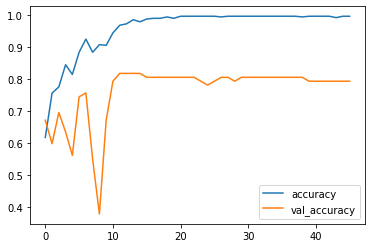

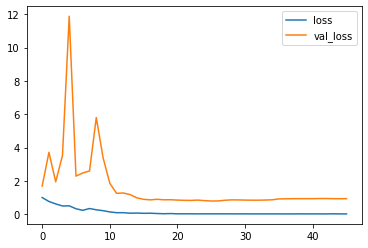

In [48]:
history = model_Xception_smallds.fit(generator.flow(train_imgs_2_tran, 
                                   train_df_2_tran,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs_2_tran)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs_2_tran, val_df_2_tran))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [49]:
model_Xception_smallds.evaluate(test_imgs_1_tran, test_df_1_tran) 
# big datasets accuracy

5/5 [==============================] - 0s 67ms/step - loss: 0.7854 - accuracy: 0.8235


[0.7854294776916504, 0.8235294222831726]

In [50]:
model_Xception_smallds.evaluate(test_imgs_2_tran, test_df_2_tran) 
# small datasets accuracy

5/5 [==============================] - 0s 67ms/step - loss: 0.6673 - accuracy: 0.8309


[0.6673104166984558, 0.8308823704719543]

## transfer learning test

In [51]:
model_Xception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [52]:
from tensorflow.keras.models import Model
pretrained_model = Model(inputs = model_Xception.input, outputs = model_Xception.get_layer('global_average_pooling2d').output)
pretrained_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception_input (InputLayer)  [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 20,861,480
Trainable params: 20,806,952
Non-trainable params: 54,528
_________________________________________________________________


In [53]:
from tensorflow.keras.models import Model
def create_model_tran():
  pretrained_model = Model(inputs = model_Xception.input, outputs = model_Xception.get_layer('global_average_pooling2d').output)
  pretrained_model.trainable = True
#   pretrained_model.trainable = False
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(4, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model_Xception_2 = create_model_tran()
model_Xception_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 2048)              20861480  
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [54]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
14/14 [==============================] - 11s 508ms/step - loss: 0.7644 - accuracy: 0.7229 - val_loss: 0.9415 - val_accuracy: 0.7561
Epoch 2/100
14/14 [==============================] - 7s 455ms/step - loss: 0.4759 - accuracy: 0.8333 - val_loss: 2.6190 - val_accuracy: 0.6585
Epoch 3/100
14/14 [==============================] - 7s 456ms/step - loss: 0.4877 - accuracy: 0.8333 - val_loss: 1.2962 - val_accuracy: 0.7317
Epoch 4/100
14/14 [==============================] - 7s 473ms/step - loss: 0.3575 - accuracy: 0.8939 - val_loss: 3.4283 - val_accuracy: 0.5610
Epoch 5/100
14/14 [==============================] - 7s 457ms/step - loss: 0.2709 - accuracy: 0.9091 - val_loss: 5.2540 - val_accuracy: 0.5610
Epoch 6/100
14/14 [==============================] - 7s 456ms/step - loss: 0.1939 - accuracy: 0.9372 - val_loss: 5.8391 - val_accuracy: 0.4268
Epoch 7/100
14/14 [==============================] - 7s 462ms/step - loss: 0.2137 - accuracy: 0.9221 - val_loss: 0.9683 - val_accuracy: 0.804

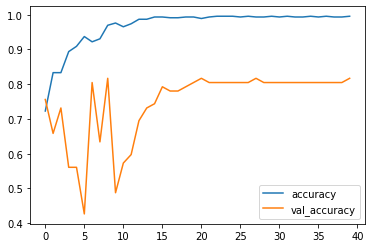

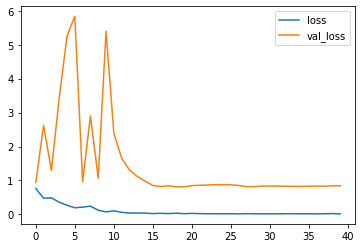

In [55]:
history = model_Xception_2.fit(generator.flow(train_imgs_2_tran, 
                                   train_df_2_tran,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs_2_tran)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs_2_tran, val_df_2_tran))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [56]:
model_Xception_2.evaluate(test_imgs_1_tran, test_df_1_tran) 

5/5 [==============================] - 0s 65ms/step - loss: 0.8573 - accuracy: 0.8235


[0.8572573661804199, 0.8235294222831726]

In [57]:
model_Xception_2.evaluate(test_imgs_2_tran, test_df_2_tran) 

5/5 [==============================] - 0s 65ms/step - loss: 0.7761 - accuracy: 0.8382


[0.7761387825012207, 0.8382353186607361]

## Save the model

In [ ]:
model_Xception.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


## Build the model (EfficientNetB0)

In [ ]:
!pip install -q efficientnet >> /dev/null
import efficientnet.tfkeras as efn

def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model_Efficient = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model_Efficient.summary()

16818176/16804768 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 5124      
Total params: 4,054,688
Trainable params: 4,012,672
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

In [ ]:
history = model_Efficient.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=1000,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

Epoch 1/1000


KeyboardInterrupt: ignored

In [ ]:
model_Efficient.evaluate(test_imgs, test_df) 

In [ ]:
predictions = model_Efficient.predict(test_imgs, steps=len(test_df), verbose=1)
y_pred = np.argmax(predictions, axis=1)

y_true = test_df_1['disease'].tolist()

from sklearn.metrics import classification_report, f1_score

f1_score(y_true, y_pred, average='weighted')

In [ ]:
#300 B3 83.5
#400 B0 72.8
#400 B0 4 class 48 batch size -- 80.8 acc 
#400 B0 4 class 8 batch size -- 0.845588207244873 acc 0.6309579109532658 f1

## Build model(resNet50)

In [ ]:
def create_model():
  pretrained_model = tf.keras.applications.ResNet50(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False)
  pretrained_model.trainable = True
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
model_resnet50 = create_model()
model_resnet50.summary()

In [ ]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 



es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

In [ ]:
history = model_resnet50.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [ ]:
model_resnet50.evaluate(test_imgs, test_df) 

In [ ]:
predictions = model_resnet50.predict(test_imgs, steps=len(test_df), verbose=1)
y_pred = np.argmax(predictions, axis=1)

y_true = test_df_1['disease'].tolist()

from sklearn.metrics import classification_report, f1_score

f1_score(y_true, y_pred, average='weighted')